# Develop score-based long short allocator

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import afterthought.backtester as bt
from afterthought.trigger import Timer
import empyrical as ep

In [2]:
plt.rcParams["figure.figsize"] = (9, 6)

# Load stock price, calculate rolling sharpe ratio, and make quantile score 

## Stock price

In [3]:
price = pd.read_csv('../data/test_price.csv', index_col='date')
price.index = pd.to_datetime(price.index)

In [4]:
price.head()

,CSCO,UAL,ISRG,PRGO,SUSA,TPR,DVN,CE,MRO,BA,...,AAPL,MKC,WY,APD,GRMN,AEE,HLT,DLTR,CRY,HAS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,24.416534,66.34,175.190000,162.572711,85.370881,32.853412,58.128642,55.255171,26.697143,117.448082,...,102.318285,68.916201,31.247737,122.542377,44.890520,40.376812,72.079783,70.35,11.120661,50.080551
2015-01-05,23.930149,66.15,171.456667,160.894592,83.873495,32.342691,55.973610,53.376182,25.455632,116.634667,...,99.435816,67.751289,31.247737,118.624189,43.652573,39.972956,69.745666,69.62,11.120661,50.226319
2015-01-06,23.921306,64.58,173.263333,160.592140,83.080177,31.964054,54.829345,52.565638,25.072911,115.260900,...,99.445174,67.443752,31.213123,118.582058,43.123244,39.507644,69.106562,68.67,11.021811,49.570361
2015-01-07,24.142390,65.53,174.213333,163.275180,83.992492,32.950272,55.086805,53.210389,25.380955,117.050413,...,100.839616,69.242376,31.308312,119.862842,43.925776,39.814925,70.218047,70.83,11.357902,49.807235
2015-01-08,24.328101,66.64,177.666667,167.002166,85.321398,33.786797,57.041590,54.269623,25.894362,119.120102,...,104.714103,70.379331,31.645798,122.635065,43.925776,39.955397,72.163145,71.11,11.614913,50.107882


## Rolling sharpe ratio

In [5]:
# rolling sharpe ratio 
ret = (price.diff()/price).fillna(0)

roll_sharpe = pd.DataFrame(0,
                          columns=price.columns,
                          index=price.index)

roll_window = 42
for col, r in ret.iteritems():
    sharpe = ep.roll_sharpe_ratio(r, roll_window)
    roll_sharpe[col] = sharpe

In [6]:
roll_sharpe.dropna().head()

,CSCO,UAL,ISRG,PRGO,SUSA,TPR,DVN,CE,MRO,BA,...,AAPL,MKC,WY,APD,GRMN,AEE,HLT,DLTR,CRY,HAS
date,,,,,,,,,,,,,,,,,,,,,
2015-03-04,1.007868,0.274639,-1.456995,-1.517507,0.282199,2.231255,0.072106,-0.384978,-0.626048,4.235521,...,3.303800,0.367234,-1.770395,1.561355,-1.212606,-2.646190,2.733529,2.891260,-1.211659,3.191597
2015-03-05,0.988030,0.119619,-1.514763,-1.168012,0.394739,2.304270,-0.210352,-0.557596,-0.778935,4.255823,...,2.909700,0.312257,-1.926342,1.582393,-0.753401,-2.378536,2.796981,3.084511,-0.860478,3.191597
2015-03-06,1.139407,-0.101834,-1.245748,-1.404833,0.489705,2.290710,-0.034073,-0.171669,-0.359211,4.201137,...,3.679029,0.303285,-2.864202,2.206947,-0.649502,-2.778079,3.002847,3.457660,-1.331769,2.775008
2015-03-09,1.426570,0.128033,-1.639226,-0.791847,1.151180,2.455889,-0.013292,0.172174,-0.406804,4.806176,...,3.770124,0.664703,-2.240088,2.449476,-0.531721,-2.112477,3.313550,3.925601,-1.131083,3.263886
2015-03-10,0.763183,-0.407398,-2.087944,-1.424874,0.032719,1.664394,-0.401976,-0.559386,-0.901669,3.995609,...,2.963950,-1.019010,-2.635193,1.794443,-0.799800,-2.092927,2.525530,3.219807,-1.711729,2.873611


## Quantile score by sharpe ratio

In [7]:
# score by sharp quantile
score = pd.DataFrame(0,
                     columns=price.columns,
                     index=price.index)

In [8]:
for t, sharpe_t in roll_sharpe.iterrows():
    bin_t = np.quantile(sharpe_t, np.arange(0.1, 1.01, 0.1))
    score_t = np.digitize(sharpe_t, bin_t)
    score.loc[t, :] = score_t

In [9]:
score.tail()

,CSCO,UAL,ISRG,PRGO,SUSA,TPR,DVN,CE,MRO,BA,...,AAPL,MKC,WY,APD,GRMN,AEE,HLT,DLTR,CRY,HAS
date,,,,,,,,,,,,,,,,,,,,,
2017-12-22,8,8,2,3,8,7,7,3,8,8,...,8,4,3,7,5,0,9,9,1,3
2017-12-26,8,7,2,3,8,7,8,4,8,9,...,7,4,4,6,4,0,9,9,1,2
2017-12-27,8,7,2,4,8,7,7,3,8,9,...,6,4,3,3,5,0,9,8,1,1
2017-12-28,8,7,2,3,7,7,6,4,7,9,...,5,4,2,4,5,0,9,8,1,1
2017-12-29,8,8,1,3,7,7,6,3,7,9,...,3,4,2,5,5,0,9,9,1,1


# Alloctor

```python 
class Alloctor():
    def __init__(self, **kwargs)
        ...
        # pass parameters in to allocator
        
    
    def __call__(self, price_df):
        ...
        # weight is pd.Series with stock tickers as index, 
        # weight proportion as values, and date as name
        return weight
```

In [10]:
class LongShortScore():
    def __init__(self, score_df, scale_df=None, short_score=0, long_score=9):
        self.score_df = score_df
        self.scale_df = scale_df
        self.short_score = short_score
        self.long_score = long_score
        
    def __call__(self, price_data):
        score_df = self.score_df
        scale_df = self.scale_df
        short_score = self.short_score
        long_score = self.long_score
        
        date = price_data.index[-1]
        score = score_df.loc[date, :]
        weight = pd.Series(data=0, index=price_data.columns, name=date)
        
        to_short = score <= short_score
        to_long = score >= long_score

        if scale_df is None:
            short_weight = - 1 / to_short.sum()
            long_weight = 1 / to_long.sum()
        else:
            scale_short = scale_df.loc[date, to_short]
            scale_long = scale_df.loc[date, to_long]
            # short_weight = - (1/scale_short) / (1/scale_short).sum()
            short_weight = scale_short / scale_short.sum() 
            long_weight = scale_long / scale_long.sum()
        
        weight[to_short] = short_weight
        weight[to_long] = long_weight
        
        return weight
        
        

# Backtest

In [11]:
# portfolio setting
capital = 1000000
inception= '2015-03-01'
lookback_window = 20
rebalance_frequency = 42
components = price.columns

In [13]:
# moduels
port = bt.Portfolio(capital, inception, components)
allo = LongShortScore(score, None, short_score=3, long_score=6)
timer = bt.Timer(rebalance_frequency)
backtester = bt.Backtester.ByPeriod(lookback_window, timer, allo)

In [15]:
backtester(port, price)

Backtesting portfolio: 100%|████████████████████████████████████████████████████| 716/716 [00:09<00:00, 72.19it/s]


In [16]:
port.summarize()

,portfolio
Begin,2015-03-02
End,2017-12-29
CAGR,0.043381
Annual Volatility,0.077108
Sharpe Ratio,0.5893
Total Return,0.128241
Max Drawdown,-0.137962


<AxesSubplot:>

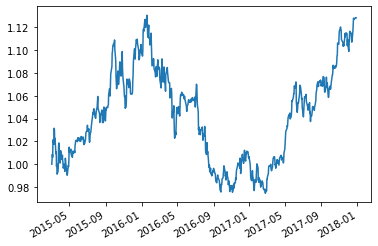

In [17]:
port.cum_returns.plot()

<AxesSubplot:>

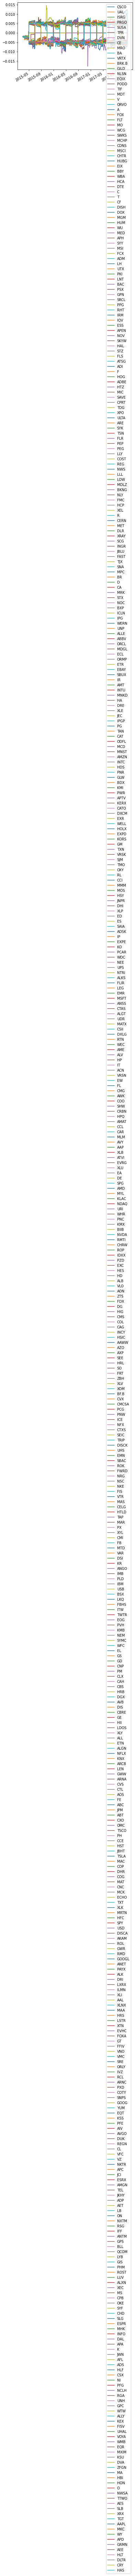

In [18]:
port.weights_close.iloc[:, :].plot()